# test

In [1]:
[1,2],[1,None]

([1, 2], [1, None])

# V2

In [2]:
# ############# learning ############
# from cgi import test
# from logging import config
# from pytorch_lightning import seed_everything

# from sklearn.calibration import log
# import torch
# ############# config##########
# import argparse
# from model.TSPN import Transparent_Signal_Processing_Network
# from trainer.trainer_basic import Basic_trainer
# from trainer.trainer_set import trainer_set
# # from configs.config import args
# # from configs.config import signal_processing_modules,feature_extractor_modules
# from configs.config import yaml_arguments,config_network
# import os
# # os.environ['CUDA_VISIBLE_DEVICES'] = '0' for test ##########################
# import argparse


# config_dir = 'configs/config_basic.yaml'


# configs,args,path = yaml_arguments(config_dir)
# seed_everything(args.seed)    
# # 初始化模型
# signal_processing_modules, feature_extractor_modules = config_network(configs,args)
# network = Transparent_Signal_Processing_Network(signal_processing_modules, feature_extractor_modules,args)

# trainer,train_dataloader, val_dataloader, test_dataloader = trainer_set(args,path)

# model = Basic_trainer(network, args)

# best_model_path = 'save/model_TSPN/time2024-03-12-19-26_lr0.001_epochs5_scale4_l1norm0.01_datasetTHU_018_basic_seed17/model-epoch=02-val_loss=1.7489.ckpt'
# state_dict = torch.load(best_model_path)
# model.load_state_dict(state_dict['state_dict'])

# # 使用最佳模型进行测试
# trainer.test(model, dataloaders=test_dataloader)

In [2]:
import scienceplots
import numpy as np
import matplotlib.pyplot as plt
import sys

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 24}
plt.style.use(['science','ieee'])

plt.rcParams['font.size'] = 24

def custom_print_decorator(func):
    def wrapper(*args, **kwargs):
        text = ' '.join(map(str, args))
        if 'file' not in kwargs or kwargs['file'] is None:
            sys.stdout.write(text + '\n')
        else:
            kwargs['file'].write(text + '\n')

        if 'folder' in kwargs and kwargs['folder']:
            with open(f'{kwargs["folder"]}/finetune_output.log', 'a') as log_file:
                log_file.write(text + '\n')
        if 'folder' in kwargs:
            del kwargs['folder']
        if 'file' in kwargs:
            del kwargs['file']
    return wrapper


# replace print to save all print into log files
print = custom_print_decorator(print)

# THU1

In [1]:
############# learning ############
from logging import config
from pytorch_lightning import seed_everything
import torch
############# config##########
import argparse
from model.TSPN import Transparent_Signal_Processing_Network
from trainer.trainer_basic import Basic_trainer
from trainer.trainer_set import trainer_set
# from configs.config import args
# from configs.config import signal_processing_modules,feature_extractor_modules
from configs.config import yaml_arguments,config_network
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' # for test ##########################
import argparse


config_dir = 'configs/THU_006/config_TSPN.yaml'


configs,args,path = yaml_arguments(config_dir)
seed_everything(args.seed)    
# 初始化模型
signal_processing_modules, feature_extractor_modules = config_network(configs,args)
network = Transparent_Signal_Processing_Network(signal_processing_modules, feature_extractor_modules,args)

trainer,train_dataloader, val_dataloader, test_dataloader = trainer_set(args,path)

model = Basic_trainer(network, args)

best_model_path = 'save/task1/TSPN/model-epoch=90-val_loss=0.1671.ckpt'
state_dict = torch.load(best_model_path)
model.load_state_dict(state_dict['state_dict'])



# 使用最佳模型进行测试
# trainer.test(model, dataloaders=test_dataloader)

/home/user/anaconda3/envs/LQ1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 17


Running experiment: time2024-03-21-10-23_lr0.001_epochs100_scale4_l1norm0.01_datasetTHU_006_basic_seed17


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# build signal processing layers
# build feature extractor layers
# build classifier


<All keys matched successfully>

## R1——模型加噪声鲁棒性

读数据

In [5]:
from torchmetrics import ConfusionMatrix
def wgn2(x, snr):
    "加随机噪声"
    snr = 10**(snr/10.0)
    xpower = torch.sum(x**2)/(x.size(0)*x.size(1)*x.size(2))
    npower = xpower / snr
    return torch.rand(x.size()).cuda() * torch.sqrt(npower)


In [3]:
test_dataset = test_dataloader.dataset.selected_data
y = test_dataloader.dataset.selected_labels
y = torch.tensor(y).cuda()
data = torch.tensor(test_dataset).cuda()
network = model.network
test_y = network(data)

In [7]:
# def calculate_accuracy_list(network, data, y, noise_dblist = [-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10],name = 'default'):

noise_dblist = [-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
name = 'TSPN'

out = network(data.cuda())
metric = ConfusionMatrix(num_classes = args.num_classes,task="multiclass").to(args.device)
confusion_matrix = metric(out.argmax(dim=1),y.to(args.device))
print(f'##### {name} #####{confusion_matrix}')

TSPN_list = []
with torch.no_grad():
    for noise in  noise_dblist:
        print('noise:',noise)
        testx_noise = data.cuda() + wgn2(data,noise)
        pred = network(testx_noise.cuda())
        acc = (pred.argmax(dim=1) == y.to(args.device)).sum().item()/len(y)
        TSPN_list.append(acc)
        del testx_noise
        del pred
        del acc
        torch.cuda.empty_cache()
        
    print(f'##### {name} #####{TSPN_list}')
    
    # return confusion_matrix, TSPN_list




##### TSPN #####tensor([[89,  0,  0,  0],
        [ 0, 89,  0,  0],
        [ 0,  0, 89,  0],
        [ 1,  0,  0, 88]], device='cuda:0')
noise: -5
noise: -4
noise: -3
noise: -2
noise: -1
noise: 0
noise: 1
noise: 2
noise: 3
noise: 4
noise: 5
noise: 6
noise: 7
noise: 8
noise: 9
noise: 10
##### TSPN #####[0.5, 0.5, 0.5, 0.5, 0.5056179775280899, 0.5168539325842697, 0.5112359550561798, 0.5280898876404494, 0.550561797752809, 0.5533707865168539, 0.5702247191011236, 0.6207865168539326, 0.6376404494382022, 0.6938202247191011, 0.699438202247191, 0.7219101123595506]


2.1.2+cu121


## R2——稀疏信号逐层可视化

找到关键operator 和parse一块类似

In [5]:
best_model_path = 'save/THU1+THU2剪枝/THU1_08/model-epoch=80-val_loss=0.1351.ckpt'
state_dict = torch.load(best_model_path)
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [6]:
import copy
id = 10
num_per_class = len(data) // args.num_classes

绘图函数

In [7]:
def compute_frequency_domain(signal, sample_rate):
    n = len(signal)
    fft_values = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(n, 1.0/sample_rate)
    return frequencies, np.abs(fft_values)

def plot_signals(signals, rows, cols, sample_rate, name):
    # 确定图像大小
    plt.figure(figsize=(12, 8))

    num_signals = signals.shape[1]
    for i in range(num_signals):
        signal = signals[:, i]
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

        # 计算当前信号应该位于的子图索引
        time_plot_index = i * 2 + 1
        freq_plot_index = i * 2 + 2

        # 绘制时域图
        plt.subplot(rows, cols, time_plot_index)
        plt.plot(signal, label=f'Channel {i+1}', c='purple')
        plt.title(f'Time Domain - Channel {i+1}')
        plt.legend()

        # 计算并绘制频域图
        frequencies, fft_values = compute_frequency_domain(signal, sample_rate)
        plt.subplot(rows, cols, freq_plot_index)
        plt.plot(frequencies, fft_values, c='darkblue')
        plt.title(f'Frequency Domain - Channel {i+1}')

    plt.tight_layout()
    plt.savefig(f'plot/{name}.pdf')
    plt.savefig(f'plot/{name}.png')
    plt.show()



/tmp/ipykernel_222082/122500989.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


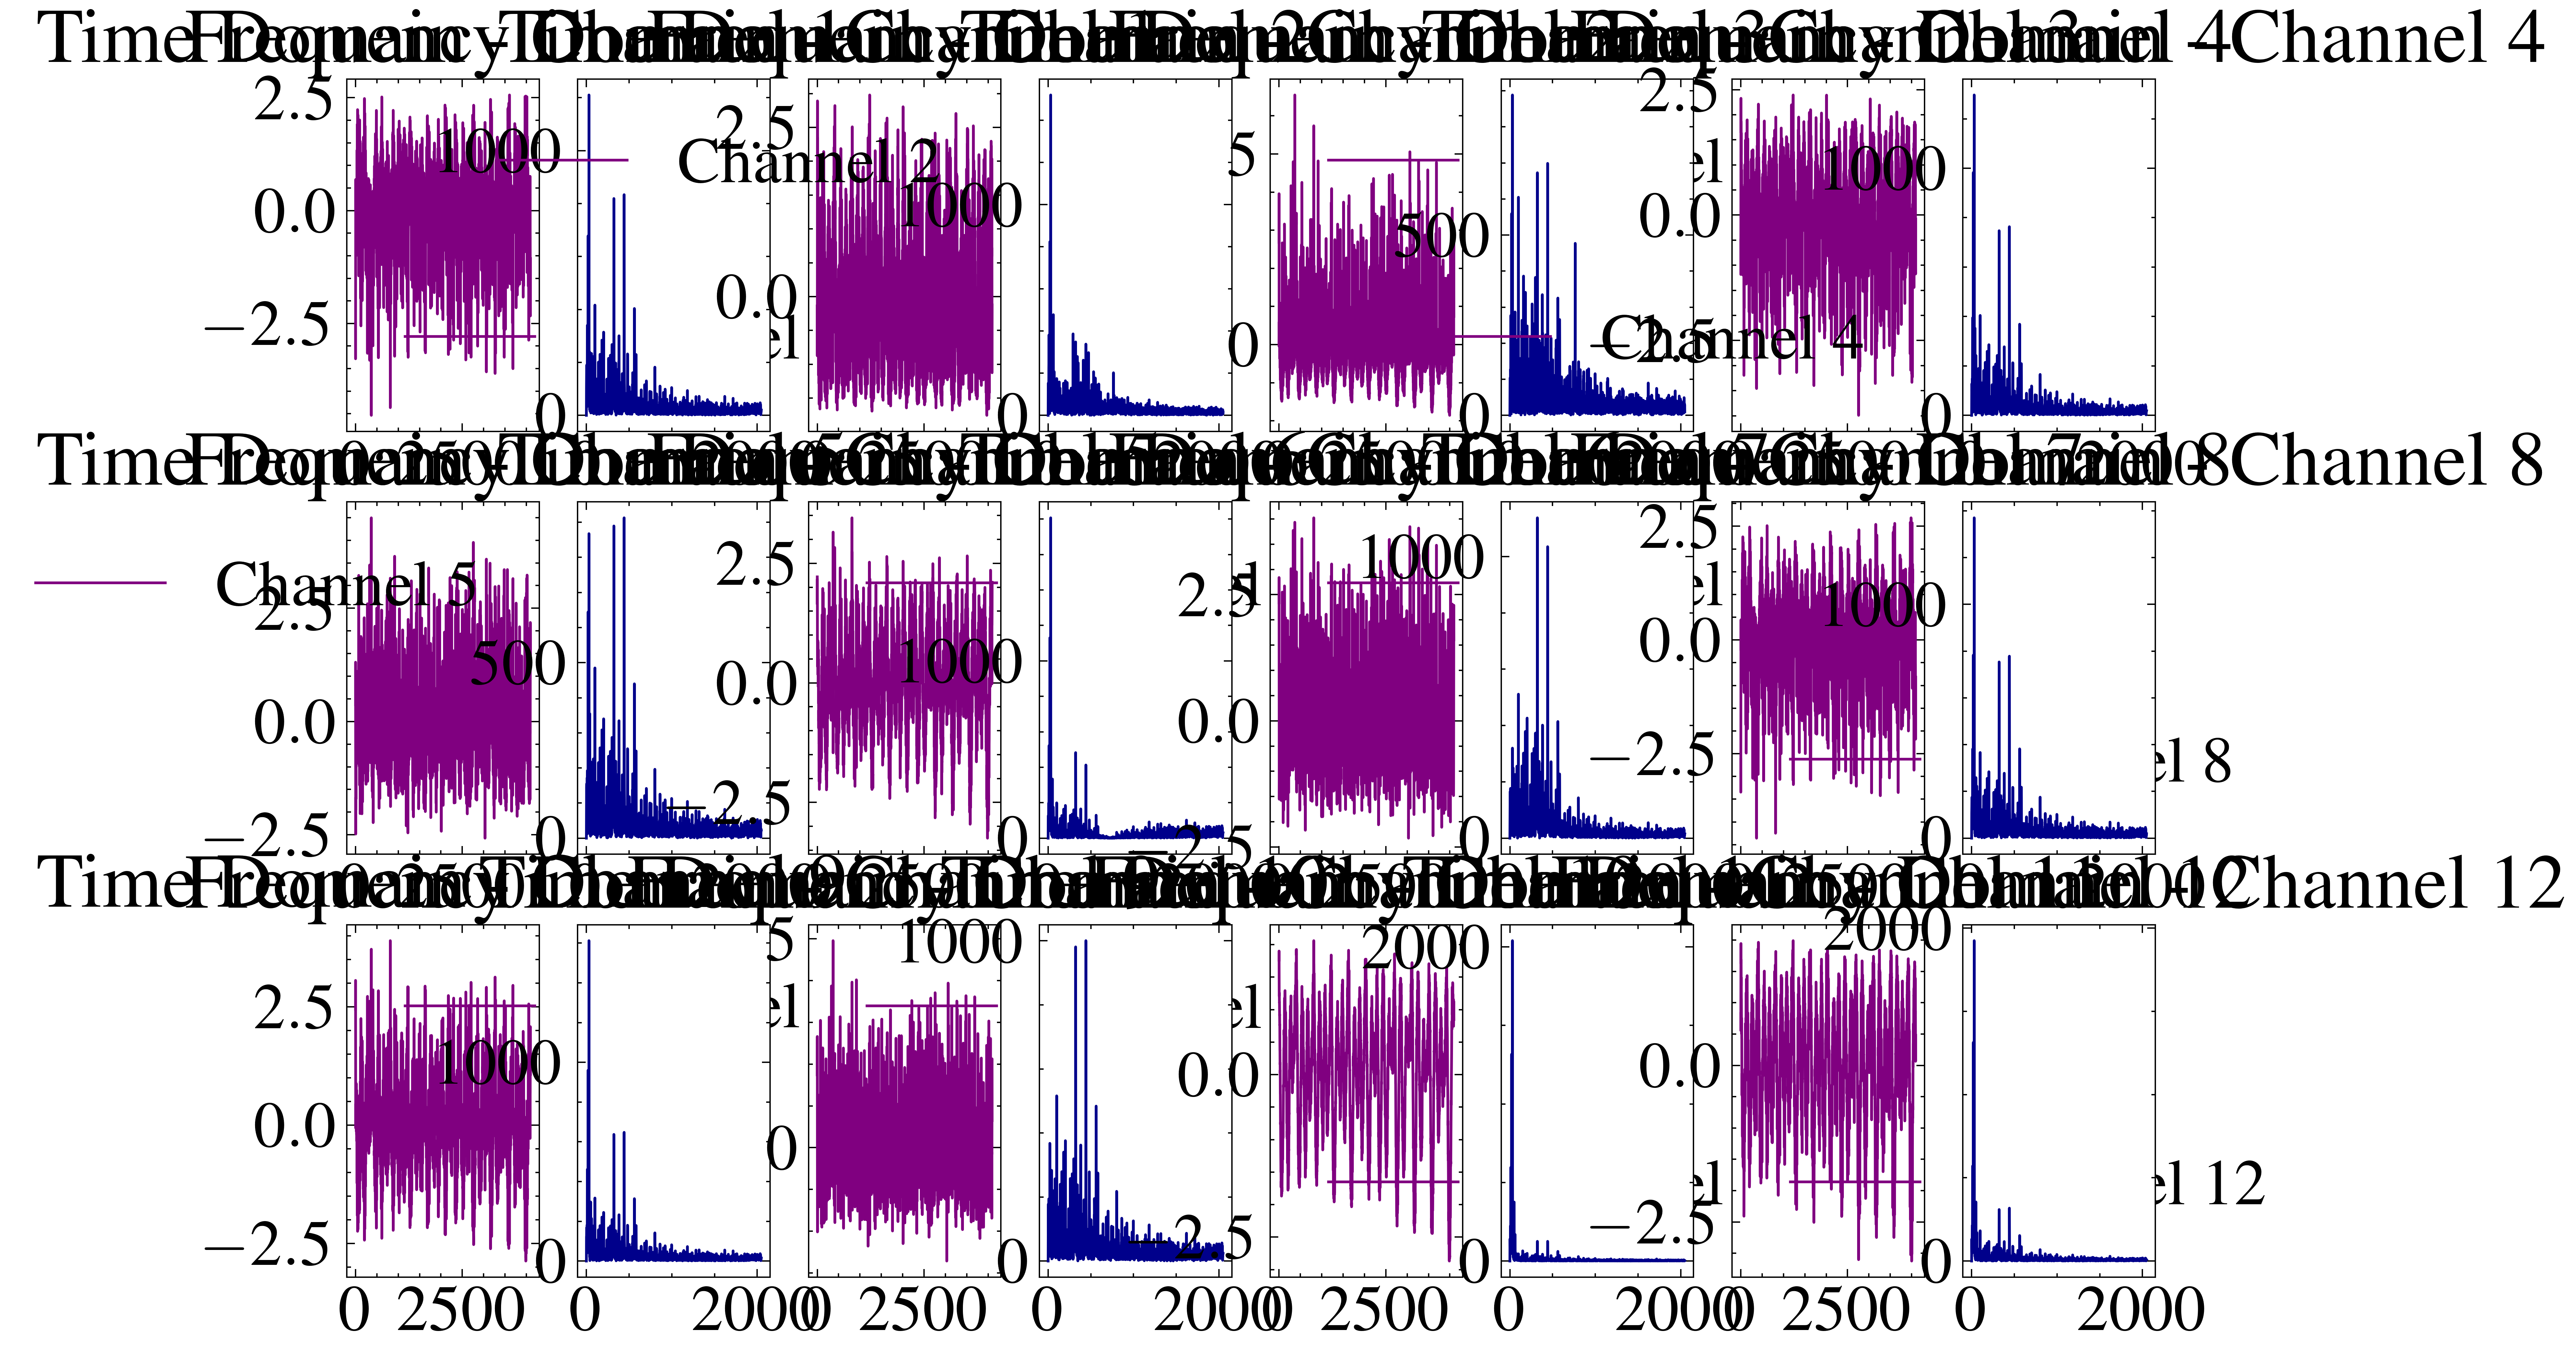

/tmp/ipykernel_222082/122500989.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


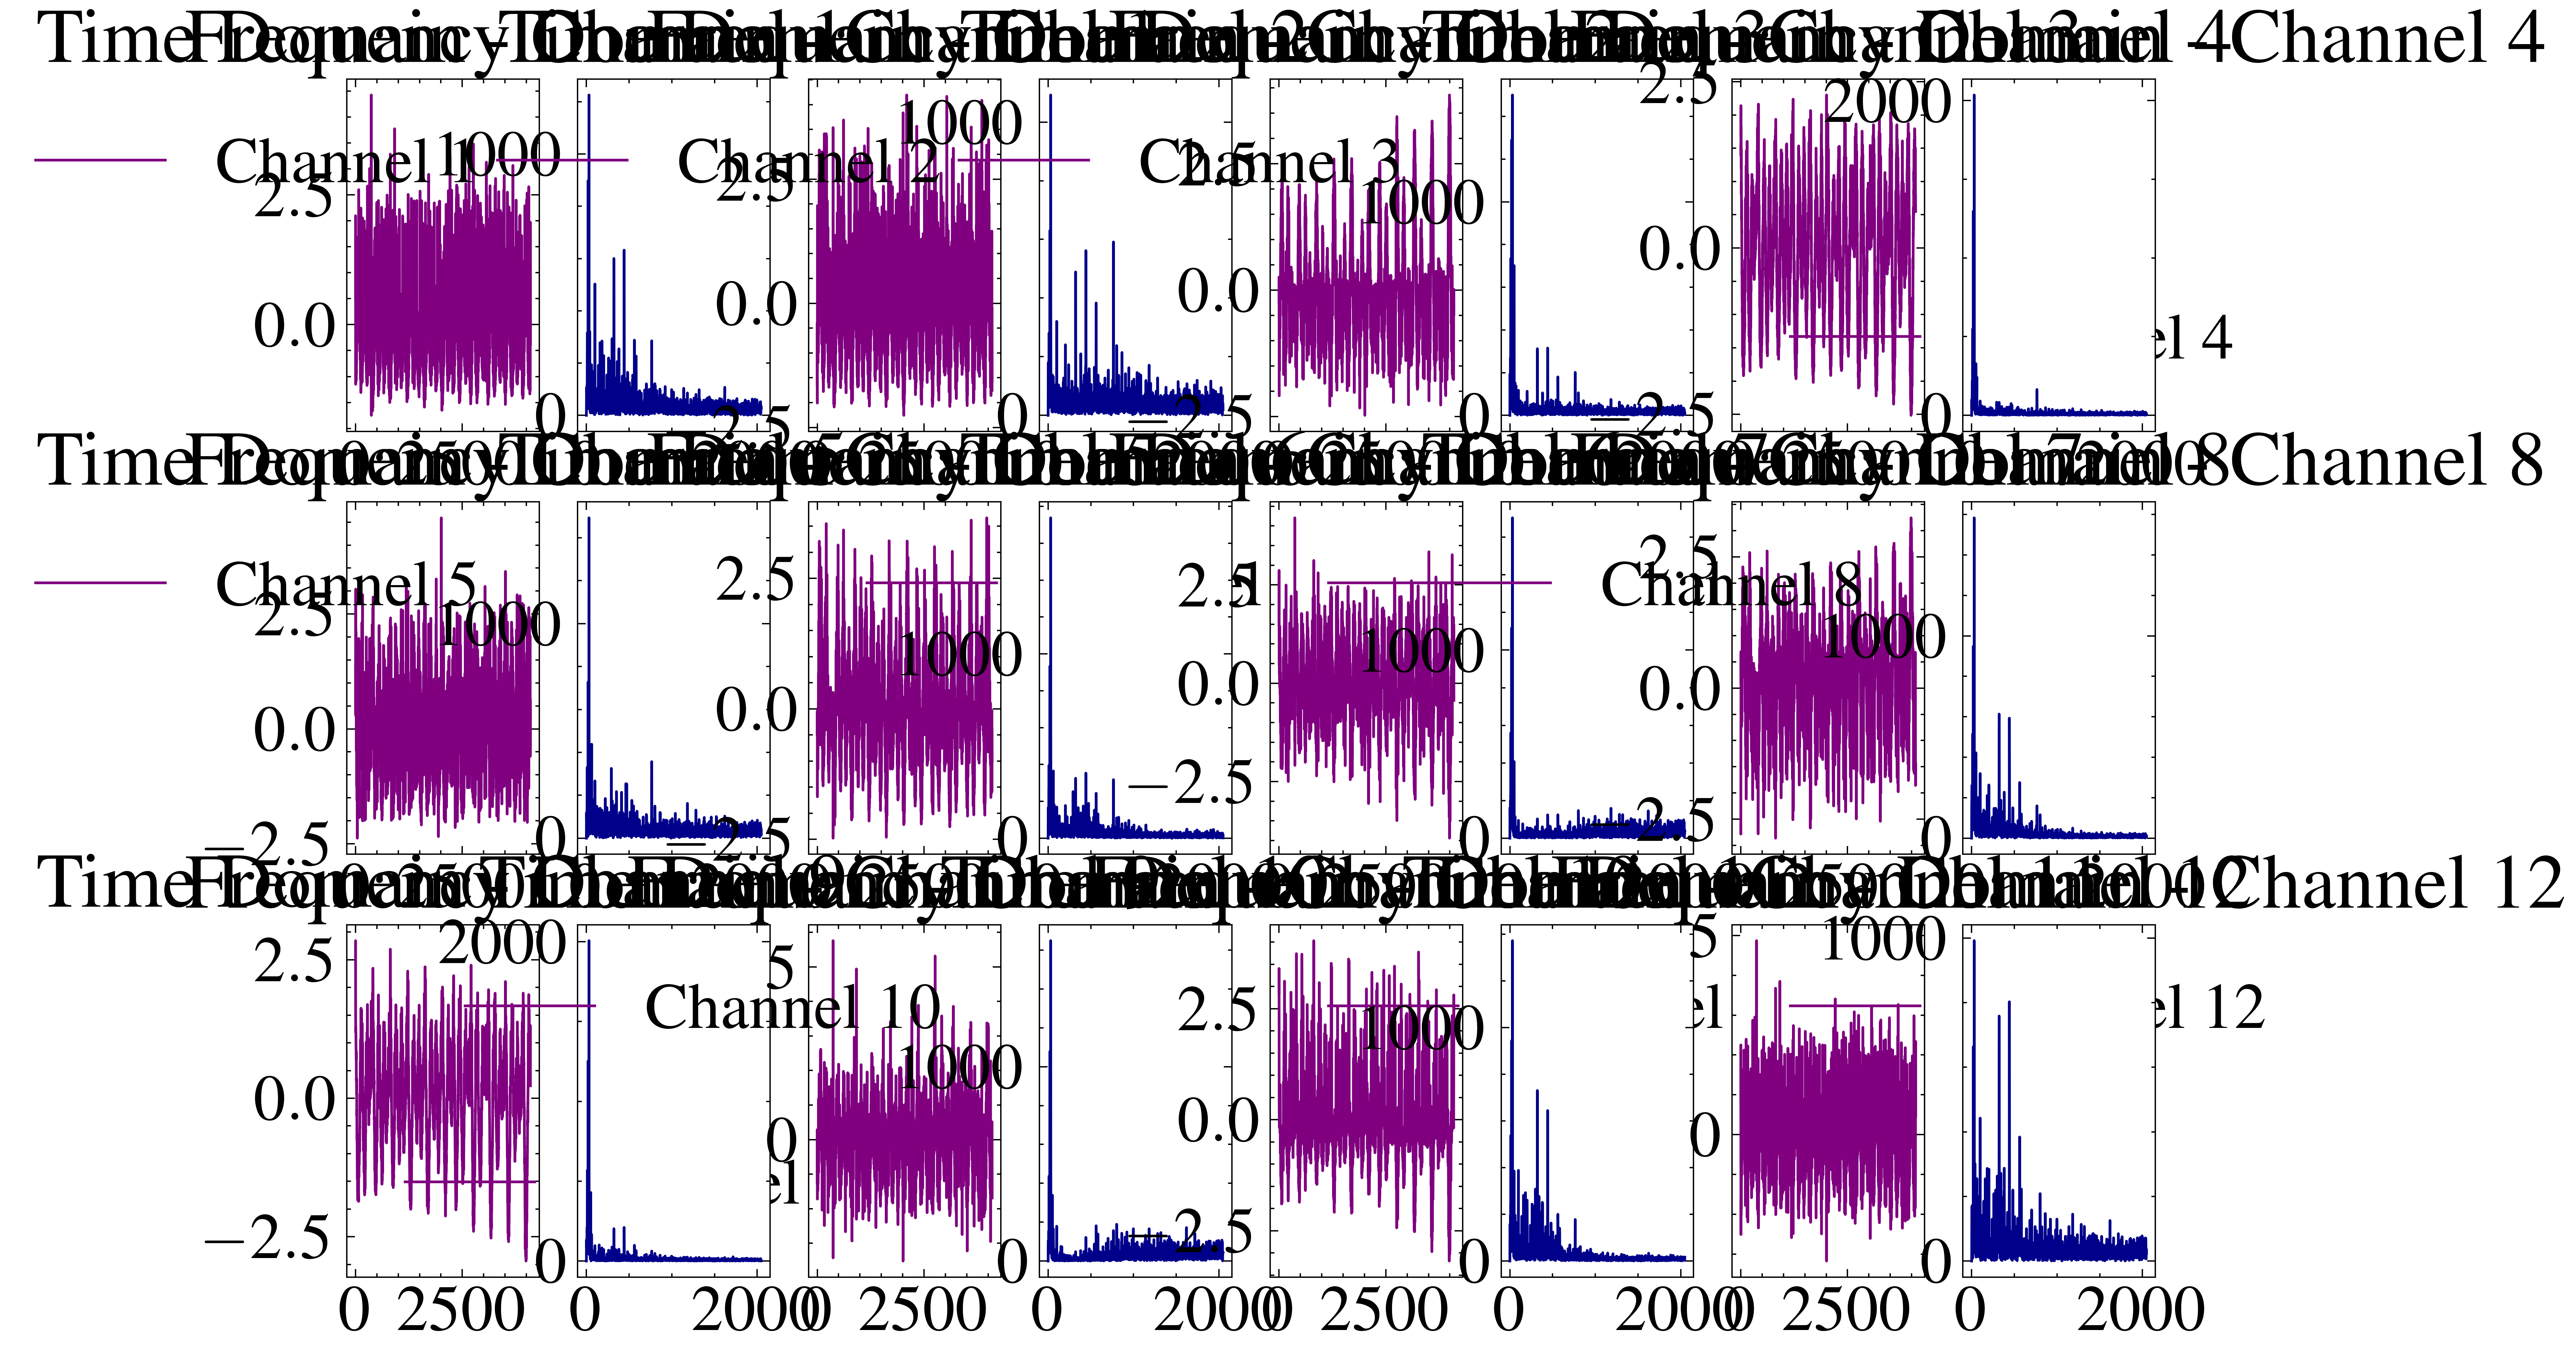

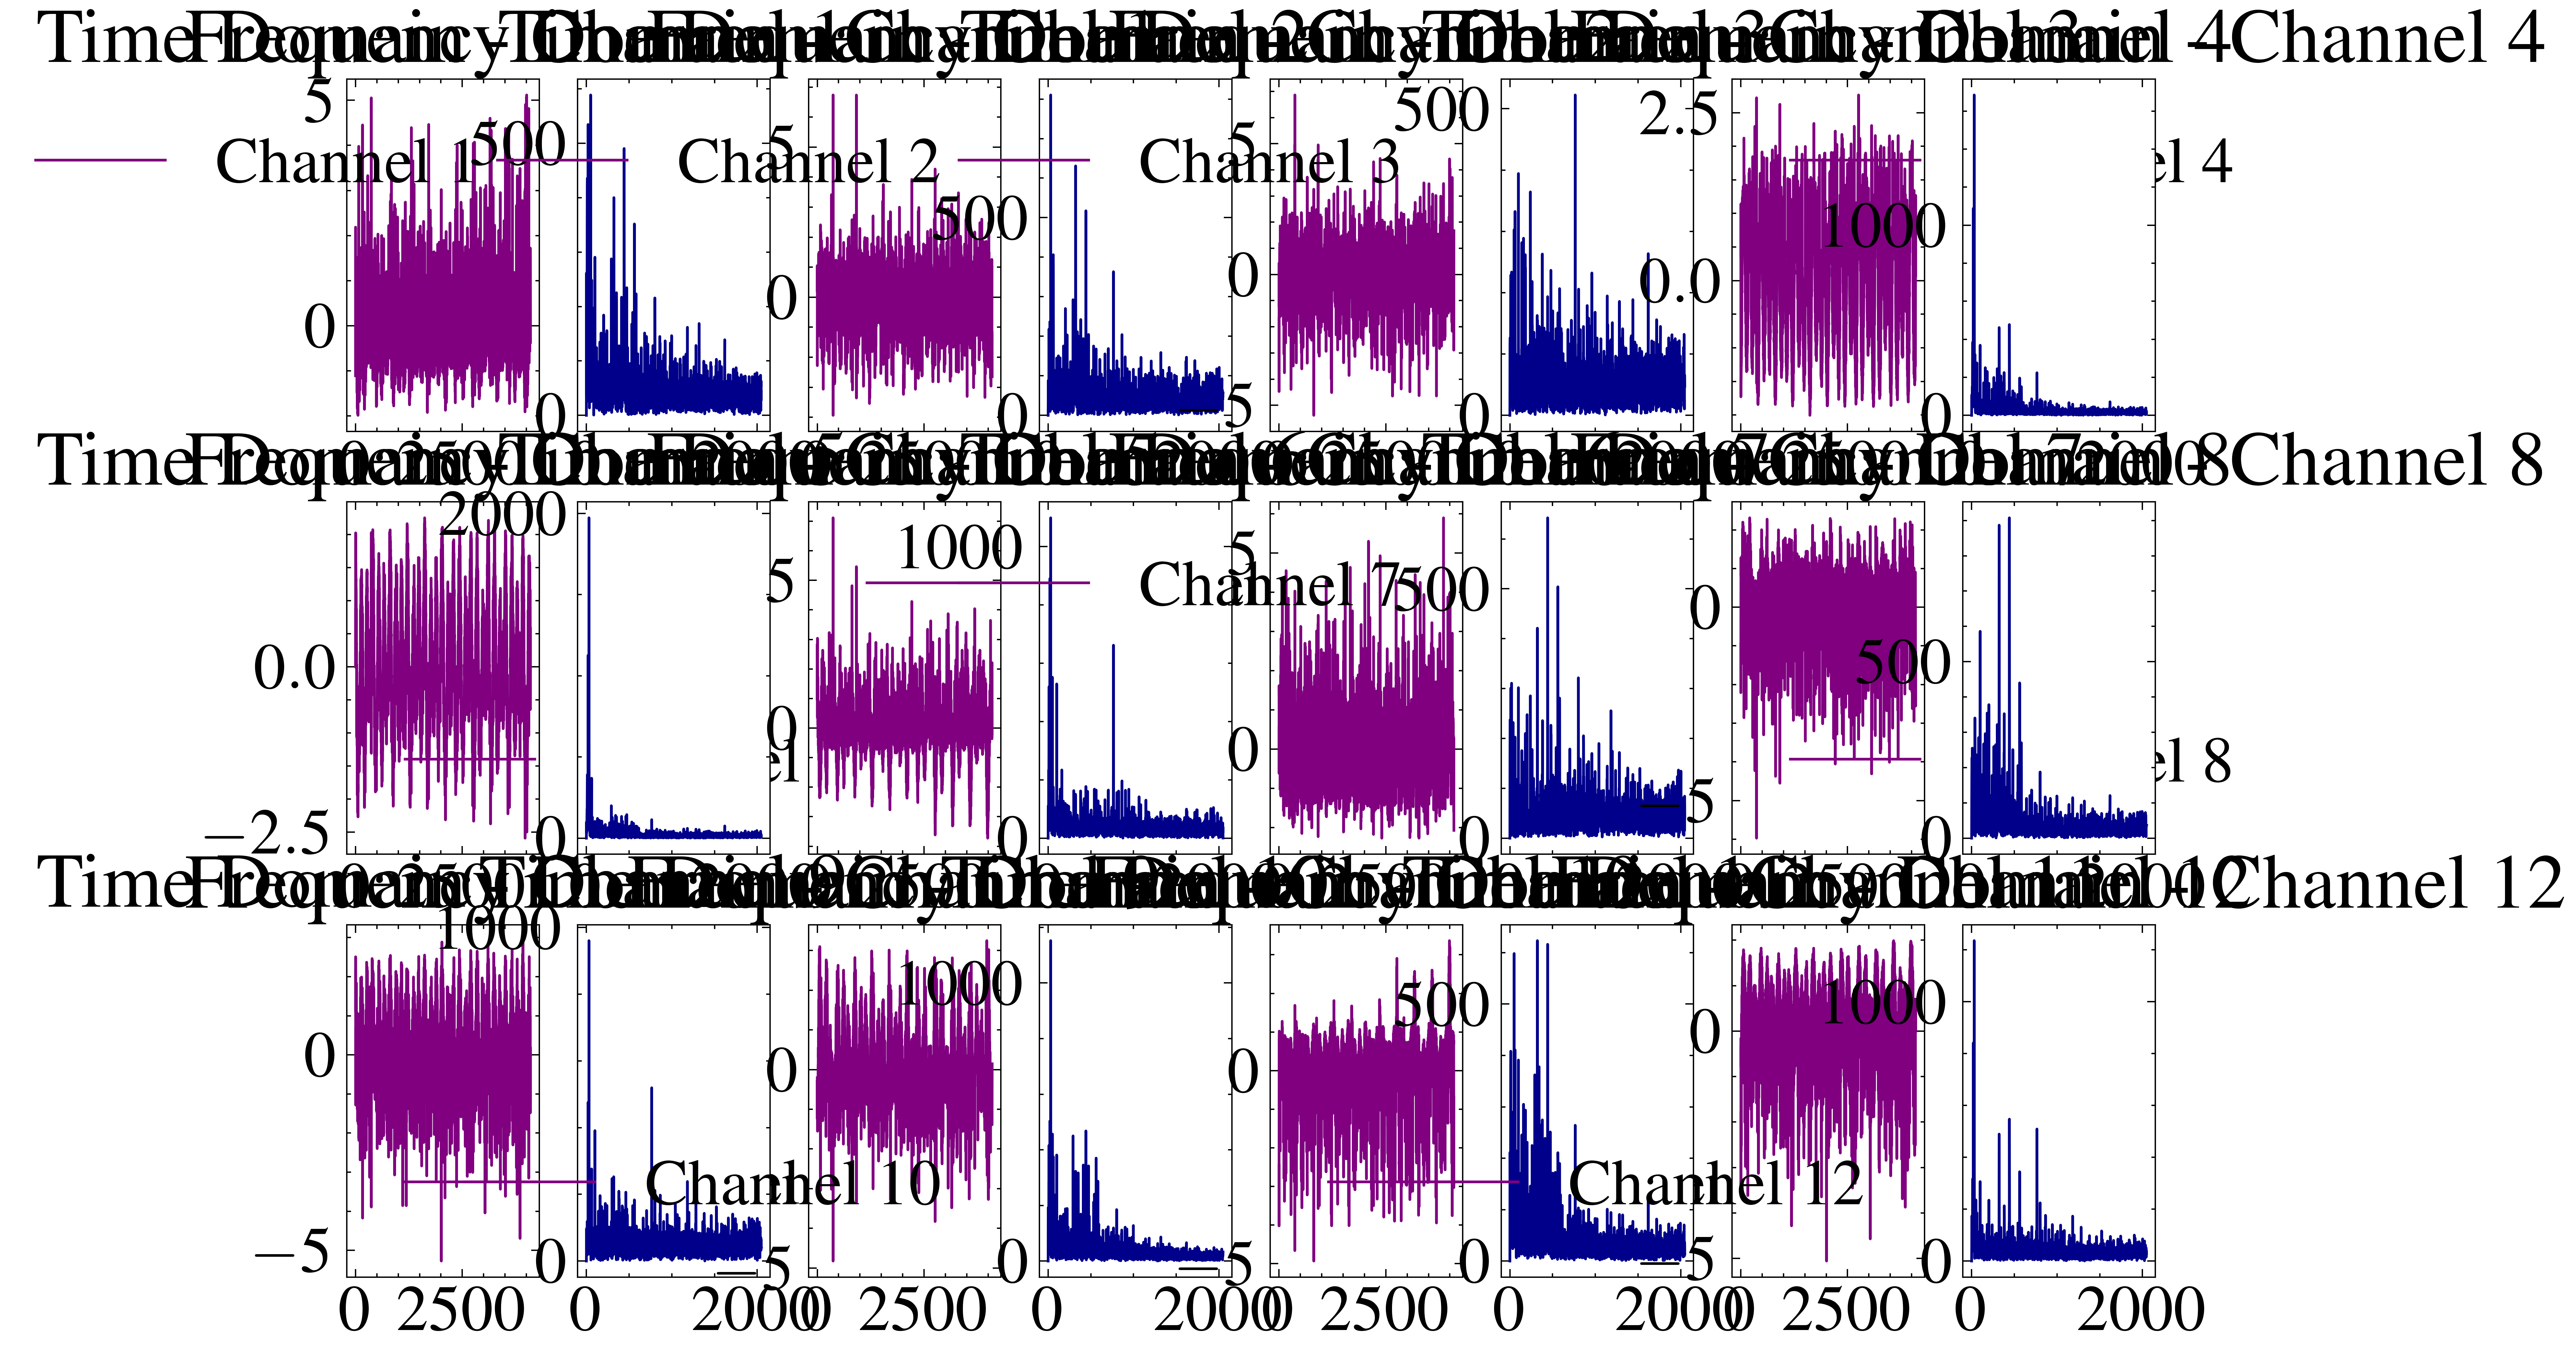

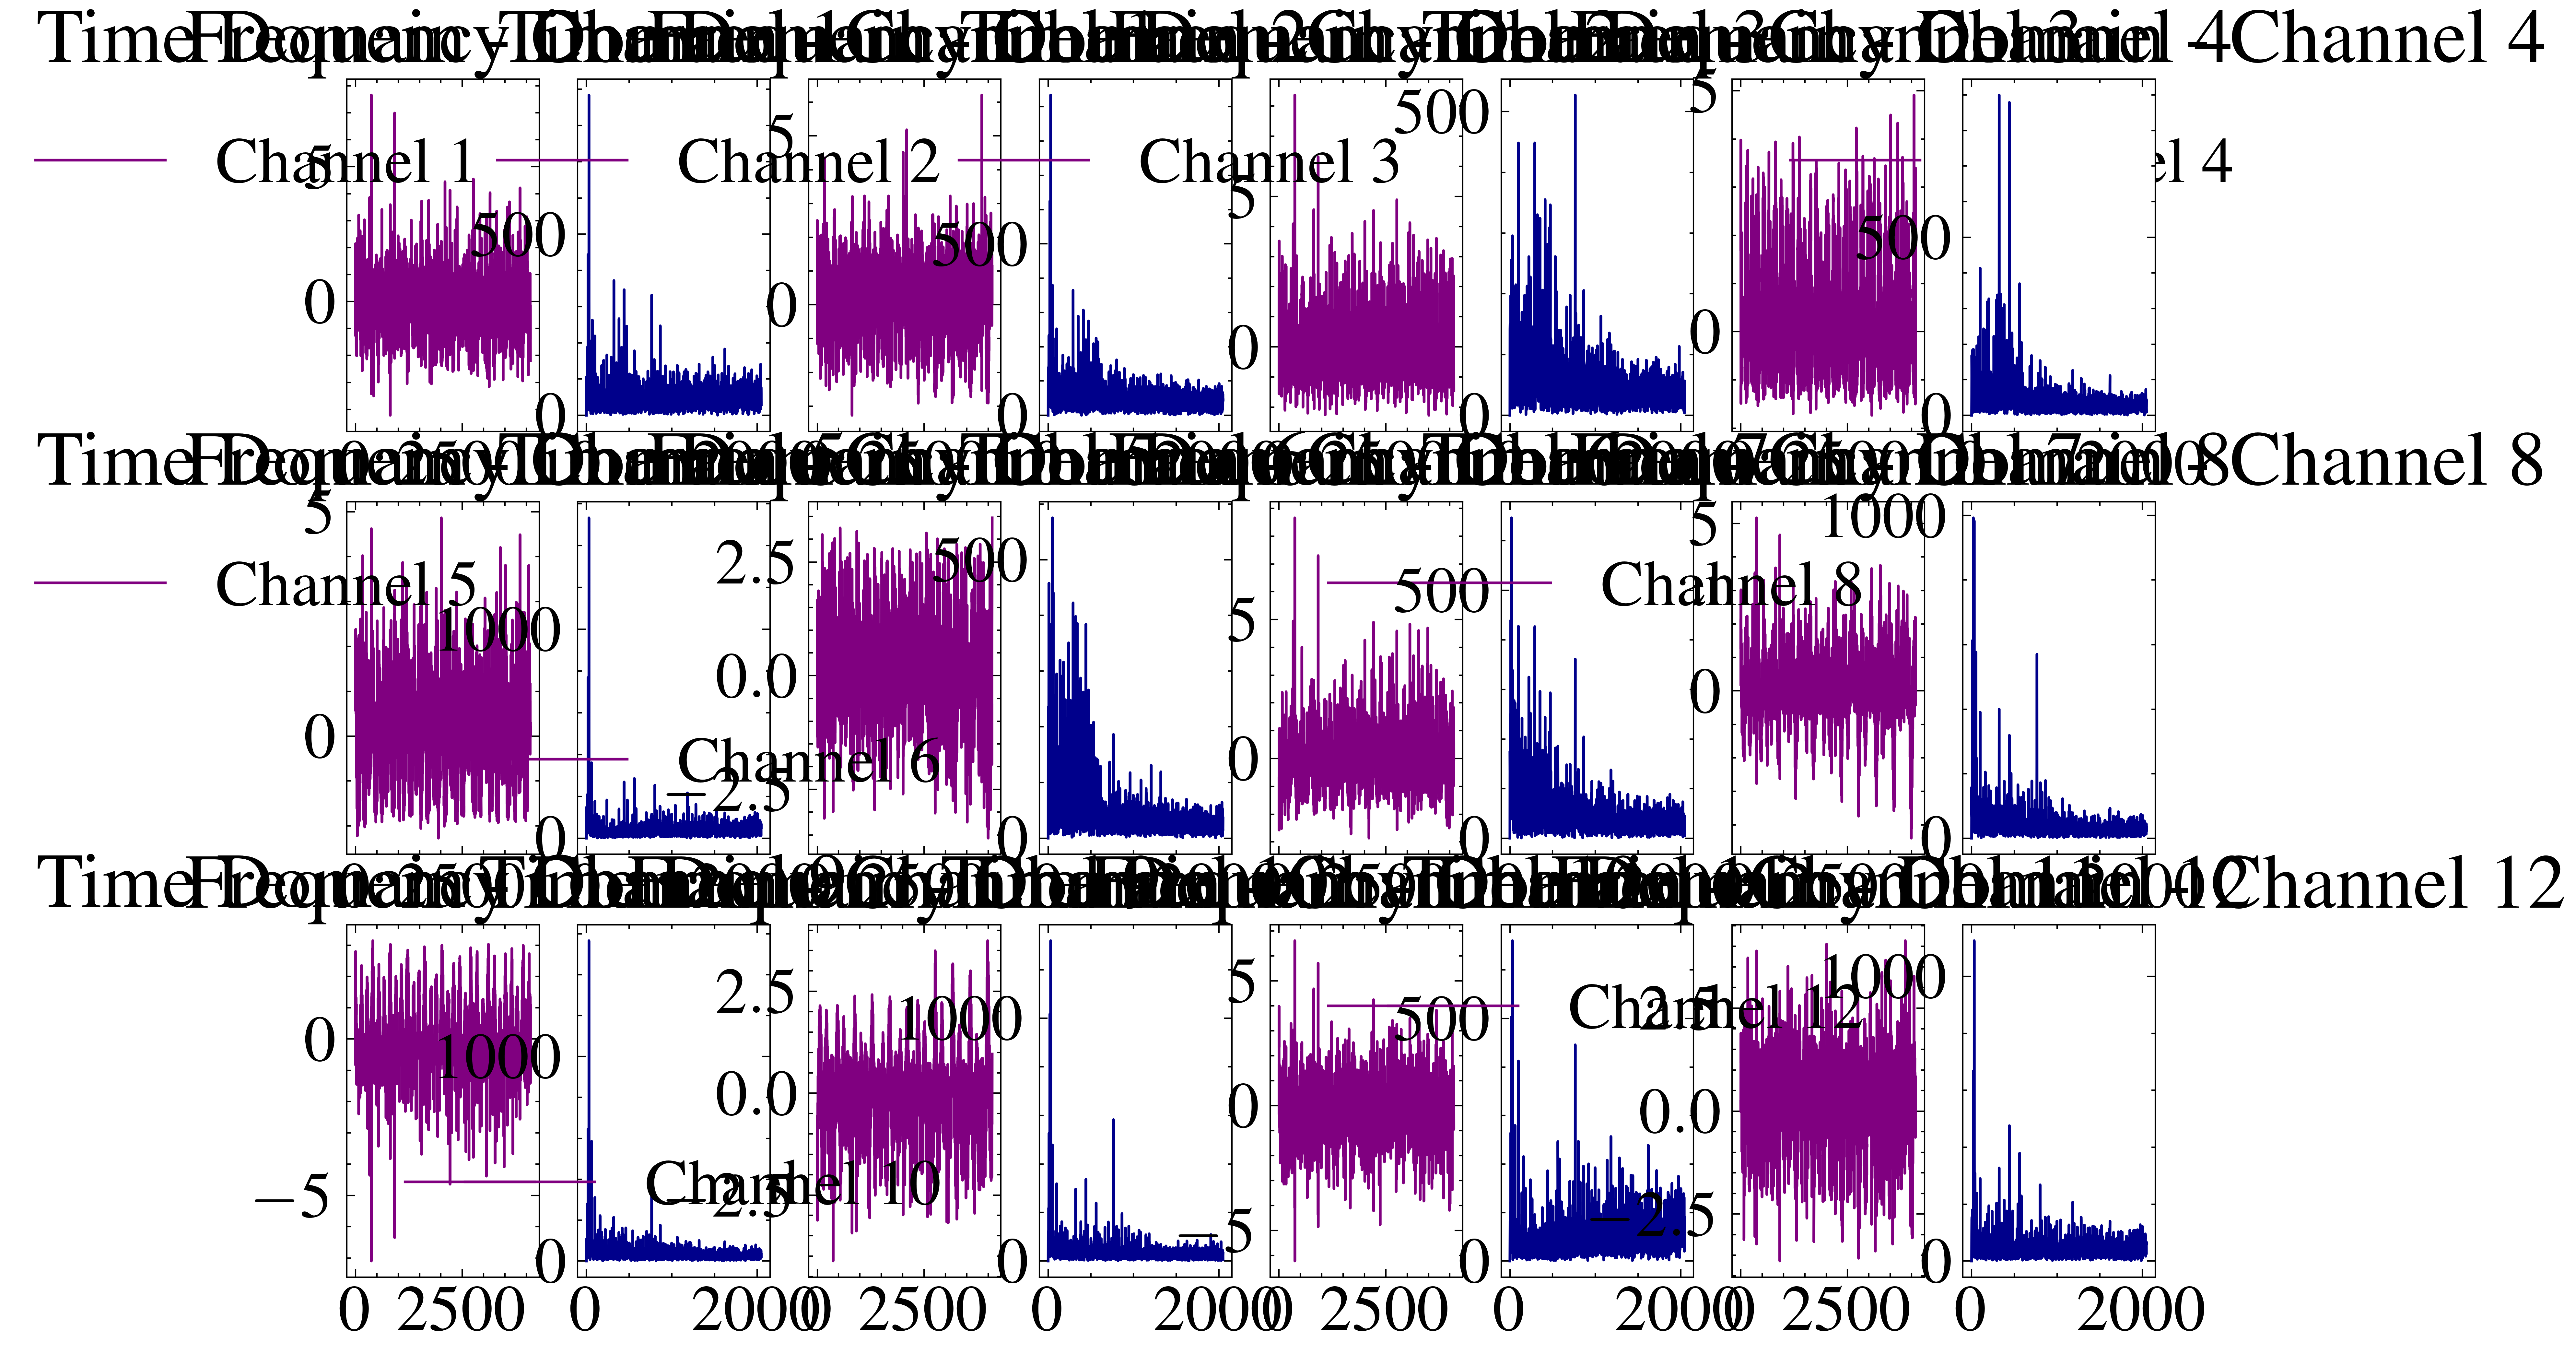

In [10]:
import copy

# Assuming "data" is defined in previous cells
signal = copy.deepcopy(data)

for idx, layer in enumerate(network.signal_processing_layers):
    signal = layer(signal)
    rows = signal.shape[-1] // 4
    cols = signal.shape[-1] * 2 // rows
    plot_signals(signals = signal[id].detach().cpu().numpy(),
                 rows = rows, cols = cols,
                 sample_rate = 4096, # 
                 name = f'layer_{idx}_sample_{id}')


## R3——特征可视化

T-SNE

单个特征可视化

## R4——泛化的变化

## R5——few-shot的变化

## R6——ablation study

传统的 ablation study ,从头训练 ，经验性验证
 对应权重置为0 ，可解释验证

## R7-模型parse

### 1. 找到关键operator

替换模型啦

In [4]:
best_model_path = 'save/THU1+THU2剪枝/THU1_08/model-epoch=80-val_loss=0.1351.ckpt'
state_dict = torch.load(best_model_path)
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [25]:

def get_top_k_weights(idx, layer,k = 10):
    print('layer:',idx)
    weight = layer.weight_connection.weight # .detach().cpu().numpy()
    
    # 计算权重的绝对值
    abs_weight = torch.abs(weight)

    # 将权重矩阵扁平化
    flat_abs_weights = abs_weight.flatten()

    # 使用 topk 方法找到扁平化权重中最大的 k 个元素及其索引
    values, flat_indices = flat_abs_weights.topk(k, largest=True)

    # 如果需要，将扁平化后的索引转换回原始矩阵的二维索引
    row_indices, col_indices = np.unravel_index(flat_indices.cpu().numpy(), abs_weight.shape)
    result_list = []

    # 在循环中将每个元素的信息添加到列表中
    for i in range(k):
        result_list.append((row_indices[i], col_indices[i], values[i].item()))
    return result_list

layer_top_weight = {}
for idx, layer in enumerate(network.signal_processing_layers):
    result_list = get_top_k_weights(idx, layer,k=20)
    layer_top_weight[f'layer:{idx}'] = result_list
    print(result_list)
    
    

layer: 0
[(5, 0, 0.6832276582717896), (4, 1, 0.6496762037277222), (8, 0, 0.6139398217201233), (2, 0, 0.5453032851219177), (11, 1, 0.5221961140632629), (10, 0, 0.4633032977581024), (1, 1, 0.43911656737327576), (10, 1, 0.4051862955093384), (8, 1, 0.39819464087486267), (1, 0, 0.343097984790802), (7, 1, 0.30707433819770813), (6, 0, 0.3022373616695404), (6, 1, 0.28355446457862854), (11, 0, 0.08653438091278076), (5, 1, 0.0716138407588005), (9, 1, 0.04742050915956497), (7, 0, 0.044268567115068436), (0, 0, 0.04405688866972923), (9, 0, 0.020347952842712402), (2, 1, 0.017998160794377327)]
layer: 1
[(2, 0, 0.19970162212848663), (1, 4, 0.19487152993679047), (1, 0, 0.19263790547847748), (5, 1, 0.18950757384300232), (9, 0, 0.18784919381141663), (4, 10, 0.18573583662509918), (10, 9, 0.1776593029499054), (10, 0, 0.17696809768676758), (1, 5, 0.17471979558467865), (2, 7, 0.1727316975593567), (6, 6, 0.17104002833366394), (5, 8, 0.16773609817028046), (7, 0, 0.16645173728466034), (9, 1, 0.16460593044757843

### 2.训练一个模型，记录所有权重和参数的变化情况，题头是参数名

# THU2